In [15]:
# Importing Libraries 
import os
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# --- TensorFlow and Keras for Model Building ---
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# --- Scikit-learn for Feature Engineering and Comprehensive Evaluation ---
from sklearn.feature_extraction.text import TfidfVectorizer

print("Libraries imported.")

Libraries imported.


In [17]:
# Configuration and Setup 

print("\n--- Phase 1: Configuration ---")
PROJECT_BASE_DIR = "C:/Users/Sreelakshmi/00_Final_Project_MENG/Approach 2"
MODEL_NAME = "MLP"
OUTPUT_DIR = os.path.join(PROJECT_BASE_DIR, MODEL_NAME)
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"All outputs will be saved in: {OUTPUT_DIR}")

IQVIA_DATA_PATH = "C:/Users/Sreelakshmi/00_Final_Project_MENG/Approach 2/Dataset_2/IQVIA_dataset.csv"
ICD_MAP_PATH = "C:/Users/Sreelakshmi/00_Final_Project_MENG/Approach 2/Dataset_2/icd_map.csv"


--- Phase 1: Configuration ---
All outputs will be saved in: C:/Users/Sreelakshmi/00_Final_Project_MENG/Approach 2\MLP


In [18]:
# --- 2. Load and Process Data ---
print("\n--- Phase 2: Loading and Processing Data ---")

# Load the main IQVIA dataset and ICD code mapping file
iqvia_data = pd.read_csv(IQVIA_DATA_PATH)
icd_map = pd.read_csv(ICD_MAP_PATH)

# Step 1: Create a binary target column (amyloidosis vs non-amyloidosis)
# If 'codes' column contains ICD codes starting with "E85", mark as 1 (amyloidosis case)
# Otherwise, mark as 0
iqvia_data['codes'] = iqvia_data['codes'].astype(str)  # ensure string type
iqvia_data['has_amyloidosis'] = iqvia_data['codes'].str.contains('E85').astype(int)

# Step 2: Prepare ICD mapping (clean codes for safe joining)
icd_map['codes'] = icd_map['codes'].str.strip()  # remove spaces around codes

# Step 3: Expand the codes into a long-format table
# - Each patient may have multiple codes separated by commas
# - 'explode' creates a new row per patient-code combination

iqvia_data['codes_list'] = iqvia_data['codes'].str.split(',')  # split codes into list
long_format_df = iqvia_data.explode('codes_list')  # un-nest list into rows

# Step 4: Merge with ICD mapping to get human-readable descriptions
# - Left join ensures all codes from patient records remain
# - Missing descriptions are filled with 'unknown_code'
merged_df = pd.merge(
    long_format_df,
    icd_map[['codes', 'short_desc']],
    left_on='codes_list',
    right_on='codes',
    how='left'
)
merged_df['short_desc'] = merged_df['short_desc'].fillna('unknown_code')


# Step 5: Create patient text history
# - For each patient, combine all ICD code descriptions into one long string
# - This creates a "clinical notes"-like feature for NLP or embedding models
tqdm.pandas(desc="Creating Patient Text Histories")
patient_histories = merged_df.groupby('patient_id')['short_desc'].progress_apply(lambda x: ' '.join(x))

# Step 6: Attach patient histories back to the original dataset
# - Index by patient_id
# - Add new column "full_text_history" with the concatenated descriptions
processed_df = iqvia_data.set_index('patient_id').join(patient_histories.rename('full_text_history'))

print("Patient text histories created.")



--- Phase 2: Loading and Processing Data ---


Creating Patient Text Histories:   0%|          | 0/15394 [00:00<?, ?it/s]

Patient text histories created.


In [5]:
# --- 3. Feature Engineering with TF-IDF ---
print("\n--- Phase 3: Feature Engineering with TF-IDF ---")

# TF-IDF (Term Frequency - Inverse Document Frequency) is used here as a "smart summarizer".
# It converts patient ICD code descriptions (text histories) into numerical features.
# Each unique word/phrase gets a weight based on how important it is across all patients.

# Limit to the top 2000 features (most informative words/terms) to keep the model efficient.
TFIDF_MAX_FEATURES = 2000

# Initialize the TF-IDF vectorizer
# - stop_words='english': removes common, less informative words (e.g., "the", "and")
# - ngram_range=(1, 2): captures both single words (unigrams) and two-word phrases (bigrams)
tfidf_vectorizer = TfidfVectorizer(
    max_features=TFIDF_MAX_FEATURES,
    stop_words='english',
    ngram_range=(1, 2)
)

# FIT the vectorizer on the patient history text and TRANSFORM it into a feature matrix
# Each row = patient, each column = TF-IDF score for a word/phrase
X_text_features = tfidf_vectorizer.fit_transform(processed_df['full_text_history']).toarray()

# Target variable: whether a patient has amyloidosis (1) or not (0)
y_target = processed_df['has_amyloidosis']

# Print the shape of the resulting TF-IDF feature matrix for confirmation
print(f"Text vectorized into a feature matrix of shape: {X_text_features.shape}")



--- Phase 3: Feature Engineering with TF-IDF ---
Text vectorized into a feature matrix of shape: (15394, 2000)


In [19]:
# --- 4. Split Data into Train, Validation, and Test Sets ---
print("\n--- Phase 4: Splitting Data ---")

# Step 1: Hold out 15% as the Test Set (for final evaluation only)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_text_features, y_target,
    test_size=0.15,
    random_state=42,
    stratify=y_target
)

# Step 2: Split the remaining 85% into Train and Validation
#   - 0.1765 ≈ 15% of the original dataset, so that:
#       Train = 70%, Validation = 15%, Test = 15%
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.1765,  # ensures exact 70/15/15 split
    random_state=42,
    stratify=y_train_val
)

print(f"Final Split Sizes -> Train: {X_train.shape[0]}, Validation: {X_val.shape[0]}, Test: {X_test.shape[0]}")



--- Phase 4: Splitting Data ---
Final Split Sizes -> Train: 10774, Validation: 2310, Test: 2310


In [20]:
# --- 5. Build the MLP Model ---

print("\n--- Phase 5: Building the MLP Model ---")
model = Sequential([
    Input(shape=(TFIDF_MAX_FEATURES,), name="tfidf_features"),
    
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(128, activation='relu'),
    Dropout(0.3),
    
    Dense(1, activation='sigmoid')
])



--- Phase 5: Building the MLP Model ---


In [21]:
# --- 6. Compile the Model ---
# Optimizer: 'adam' is a good default choice for most tasks
# Loss: 'binary_crossentropy' since this is a binary classification problem
# Metrics: 'accuracy' + AUC (area under ROC curve) to track classification quality beyond accuracy
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)


In [22]:
# --- 7. Model Summary ---
# This prints a layer-by-layer summary 
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 512)                 │       1,024,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,191,937 (4.55 MB)

 Trainable params: 1,190,401 (4.54 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [23]:
# --- 6. Train the Model ---
print("\n--- Phase 6: Training the Model ---")

# EarlyStopping:
# - monitor: 'val_auc' metric to track here
# - patience: how many epochs to wait for improvement before stopping
# - mode: 'max' because higher AUC is better
# - restore_best_weights: keep the best model after stopping
early_stopping = EarlyStopping(
    monitor='val_auc',
    patience=5,
    mode='max',
    restore_best_weights=True
)

# Fit the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],  
    verbose=1
)



--- Phase 6: Training the Model ---
Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.7556 - auc: 0.8322 - loss: 0.5127 - val_accuracy: 0.5017 - val_auc: 0.9756 - val_loss: 0.6904
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9453 - auc: 0.9896 - loss: 0.1301 - val_accuracy: 0.5835 - val_auc: 0.9726 - val_loss: 0.8254
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9620 - auc: 0.9951 - loss: 0.0841 - val_accuracy: 0.9078 - val_auc: 0.9935 - val_loss: 0.1981
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9658 - auc: 0.9962 - loss: 0.0709 - val_accuracy: 0.9628 - val_auc: 0.9967 - val_loss: 0.0869
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9714 - auc: 0.9977 - loss: 0.0587 - val_accuracy: 0.9736 - val_auc: 0.9970 - val_loss: 0.0627
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9710 - auc: 0.9973 - loss: 0.0590 - val_accuracy: 0.9688 - val_auc: 0.9969 - val_loss: 0.07

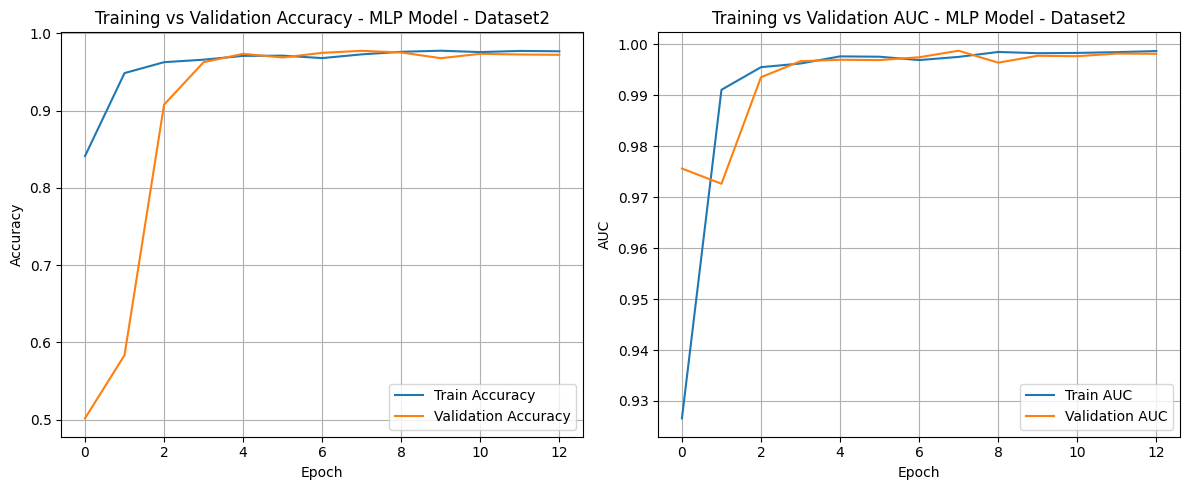

In [24]:
# --- 7. Plot Training History ---

# Accuracy Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy - MLP Model - Dataset2')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# AUC Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('Training vs Validation AUC - MLP Model - Dataset2')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [25]:
# --- 7. Save All Assets ---
print("\n--- Phase 7: Saving All Assets ---")

# Save the trained MLP model to disk
# This allows us to reload the model later without retraining
model.save(os.path.join(OUTPUT_DIR, 'mlp_model_dataset2.keras'))
print(f"Model saved to {OUTPUT_DIR}")

# Save the fitted TF-IDF vectorizer
# We need this later to transform new/unseen text data consistently
joblib.dump(tfidf_vectorizer, os.path.join(OUTPUT_DIR, 'tfidf_vectorizer.joblib'))
print(f"TF-IDF Vectorizer saved to {OUTPUT_DIR}")

# --- CREATE SUBFOLDER FOR SPLIT DATASETS ---
split_dir = os.path.join(OUTPUT_DIR, 'split_dataset')
os.makedirs(split_dir, exist_ok=True)  # Create folder if it doesn't exist

# Save training features and labels
pd.DataFrame(X_train, columns=tfidf_vectorizer.get_feature_names_out()).to_csv(os.path.join(split_dir, 'X_train.csv'))
y_train.to_csv(os.path.join(split_dir, 'y_train.csv'))

# Save validation features and labels
pd.DataFrame(X_val, columns=tfidf_vectorizer.get_feature_names_out()).to_csv(os.path.join(split_dir, 'X_val.csv'))
y_val.to_csv(os.path.join(split_dir, 'y_val.csv'))

# Save test features and labels
pd.DataFrame(X_test, columns=tfidf_vectorizer.get_feature_names_out()).to_csv(os.path.join(split_dir, 'X_test.csv'))
y_test.to_csv(os.path.join(split_dir, 'y_test.csv'))

print(f"All split data files saved as CSVs to {split_dir}")


--- Phase 7: Saving All Assets ---
Model saved to C:/Users/Sreelakshmi/00_Final_Project_MENG/Approach 2\MLP
TF-IDF Vectorizer saved to C:/Users/Sreelakshmi/00_Final_Project_MENG/Approach 2\MLP
All split data files saved as CSVs to C:/Users/Sreelakshmi/00_Final_Project_MENG/Approach 2\MLP\split_dataset
